# ABCNN Visualizations

We can better understand what features the ABCNN model is learning by looking at its attention distributions.

The attention distributions for the ABCNN-1 blocks can help us to understand word and phrasal associations between sequences that the model is finding.

First, we import the necessary modules for the visualizations.

In [45]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from model.attention.utils import manhattan
from model.attention.utils import euclidean
from model.attention.utils import cosine
from model.attention.utils import compute_attention_matrix
from model.attention.abcnn1 import ABCNN1Attention
from model.attention.abcnn2 import ABCNN2Attention
from model.blocks.abcnn1 import ABCNN1Block
from model.blocks.abcnn2 import ABCNN2Block
from model.blocks.abcnn3 import ABCNN3Block
from model.convolution.conv import Convolution
from model.model import Model
from model.pooling.allap import AllAP
from model.pooling.widthap import WidthAP
from setup import read_config
from setup import setup_word_vectors
from setup import setup_dataset
from setup import setup_embedding_matrix
from setup import setup_block
from setup import setup_model
from setup import weights_init
from setup import text_to_word_list
from utils import load_checkpoint

In [31]:
# Paths to necessary files
CONFIG_FILE = "config.json"
CHECKPOINT_FILE = "checkpoints/gpu0/best_checkpoint"
EMBEDDINGS_FILE = "/home/cody/fastText/word_vector_from_tickets_skipgram_dim300_subword_min2_max6_rename.bin"

# Move operations to GPU if one is available
USE_CUDA = torch.cuda.is_available() 

In order to generate the heat maps faithfully, we'll need to load the pre-trained word2vec model (so we can access its vocabulary) and the set of stop words we used (so we can clean the input sequences).

For this Notebook, we'll use a pre-trained ABCNN-3 models. We will also need to load in the datasets.

In [33]:
config = read_config(CONFIG_FILE)

In [34]:
# Get pre-trained word embeddings
# (Get a cup of coffee, this'll take about 10 minutes)
word_vectors = setup_word_vectors(config)

Loading FastText word vectors from: /home/cody/fastText/word_vector_from_tickets_skipgram_dim300_subword_min2_max6_rename.bin


In [6]:
# Load datasets
data_paths = config["data_paths"]
embeddings_size = config["embeddings"]["size"]
max_length = config["model"]["max_length"]
datasets = {name: pd.read_csv(data_path) for name, data_path in data_paths.items()}
for name, dataset in datasets.items():
    dataset, examples = setup_dataset(dataset, word_vectors, embeddings_size, max_length)
    datasets[name] = dataset

100%|██████████| 41238/41238 [00:38<00:00, 1073.44it/s]


In [7]:
# Create the model
model = setup_model(config)

Creating the ABCNN model...


In [8]:
# Overwrite model weights with pre-trained weights
state = load_checkpoint(CHECKPOINT_FILE)
model_dict, optim_dict, _, _ = state
model.load_state_dict(model_dict)

In [9]:
# See how to access the weights
for name, param in model.named_parameters():
    print(name, type(param.data), param.size())

blocks.0.attn1.W1 <class 'torch.Tensor'> torch.Size([15, 300])
blocks.0.conv.conv.weight <class 'torch.Tensor'> torch.Size([50, 2, 3, 300])
blocks.0.conv.conv.bias <class 'torch.Tensor'> torch.Size([50])
blocks.1.attn1.W1 <class 'torch.Tensor'> torch.Size([15, 50])
blocks.1.conv.conv.weight <class 'torch.Tensor'> torch.Size([50, 2, 3, 50])
blocks.1.conv.conv.bias <class 'torch.Tensor'> torch.Size([50])
fc.weight <class 'torch.Tensor'> torch.Size([2, 800])
fc.bias <class 'torch.Tensor'> torch.Size([2])


In [ ]:
# Make each of the blocks in the model
block_configs = config["model"]["blocks"]
block_1 = make_block("block.0.", max_length, block_configs[0])
block_2 = make_block("block.1.", max_length, block_configs[1])   

# Quora Dataset

Now that we have the pre-trained model loaded and the datasets, the first thing we can do is inspect the attention matrices themselves for a few examples.

In [53]:
quora_examples = [
    ["If someone tried to kidnap me what should I do?", "What can I do if someone tried to kidnap me?", 1],
    ["How do you write a better college essay?", "How do I write the best college application essay?", 1],
    ["What are the best-kept secrets of models?", "What are the best-kept secrets of great database models?", 0]
]

In [54]:
quora_dataset, quora_examples = setup_dataset(quora_examples, word_vectors, embeddings_size, max_length)

100%|██████████| 3/3 [00:00<00:00, 408.20it/s]


In [50]:
def make_block(block_prefix, max_length, block_config):
    """ Helper function to create one of the blocks in the model. """
    # Create the block
    block, output_size = setup_block(max_length, block_config)
    block = block.eval() # Turn off dropout
    block = block.cuda() if USE_CUDA else block # Put on GPU if available
    
    # Overwrite the block's weights
    block_dict = block.state_dict()
    for pre_name, weights in model_dict.items():
        if block_prefix in pre_name:
            name = pre_name.replace(name_prefix, "")
            if name in block_dict:
                block_dict[name] = weights
    block.load_state_dict(block_dict)
    return block

In [ ]:
def generate_heat_map(A, xticks, yticks):
    """ Generates a heat map for the attention matrix.
    
        Args:
            A: torch.Tensor of shape (batch_size, 1, max_length, max_length)
                The attention matrix.
            xticks: list of string
                The labels to use for the x-axis ticks.
            yticks: list of string
                The labels to use for the y-axis ticks.
                
        Returns:
            None
    """
    # Sanity checks
    assert(A.shape[0] == len(xticks) and A.shape[1] == len(yticks))
    
    # Make plot bigger so its easier to read
    plt.rcParams["figure.figsize"] = 10, 10
    
    # Make x-ticks and label appear on top
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
    
    # Plot the attention distribution
    plt.imshow(A, cmap="rainbow", interpolation="nearest")
    plt.xticks(range(len(xticks)), xticks, rotation=90)
    plt.yticks(range(len(yticks)), yticks)
    plt.colorbar()
    plt.show()

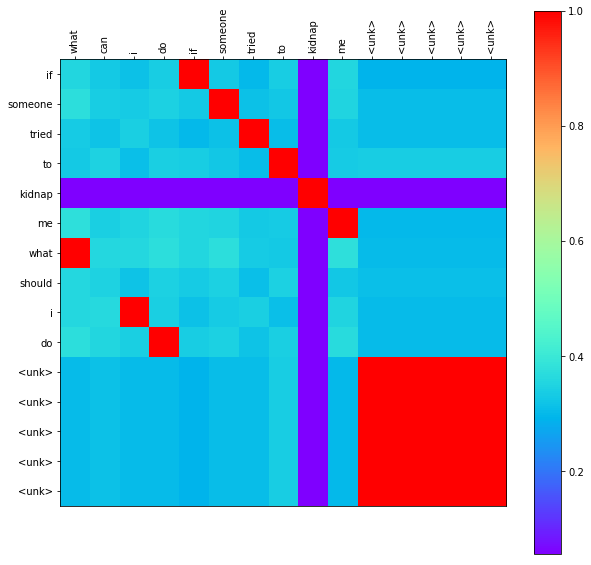

Press any key to continue...


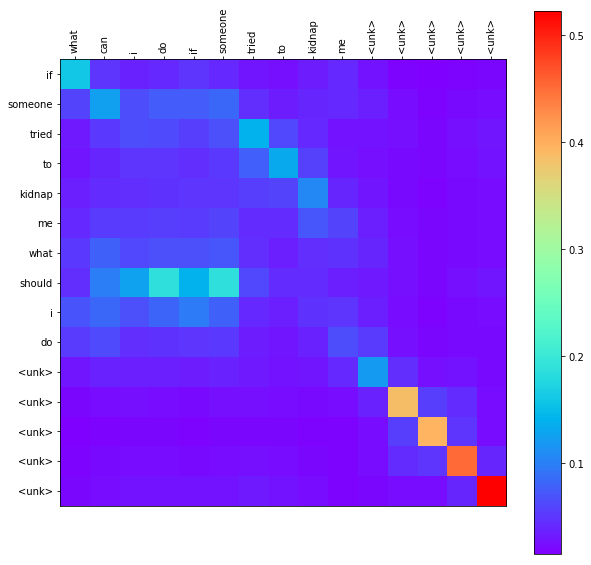

Press any key to continue...


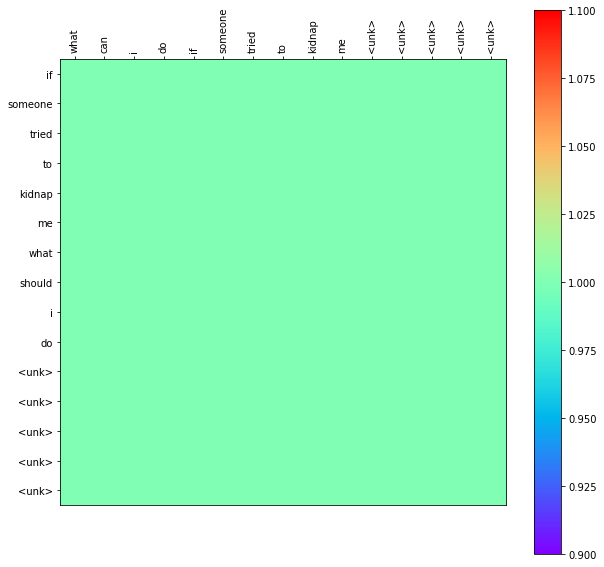

Press any key to continue...


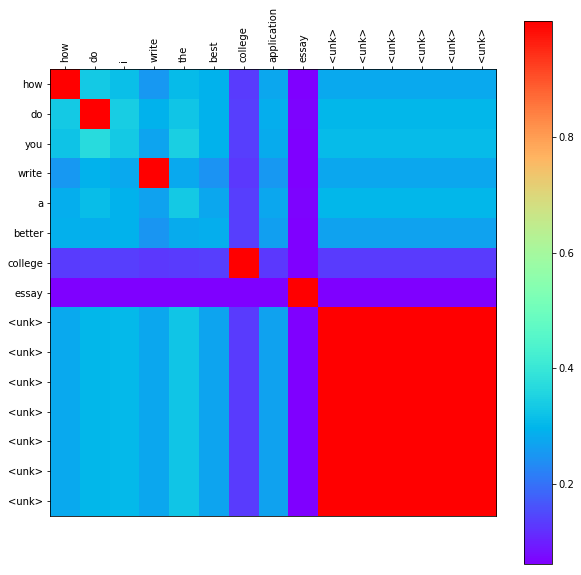

Press any key to continue...


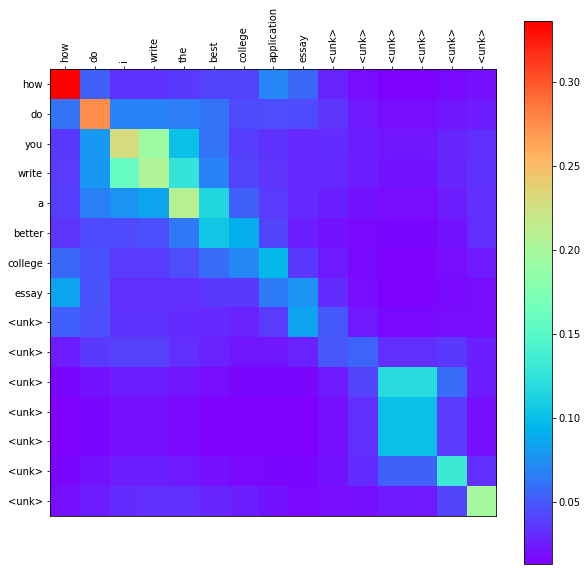

Press any key to continue...


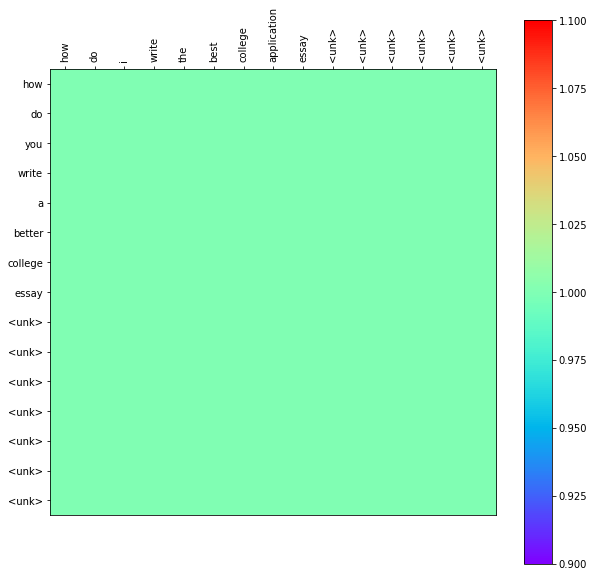

Press any key to continue...


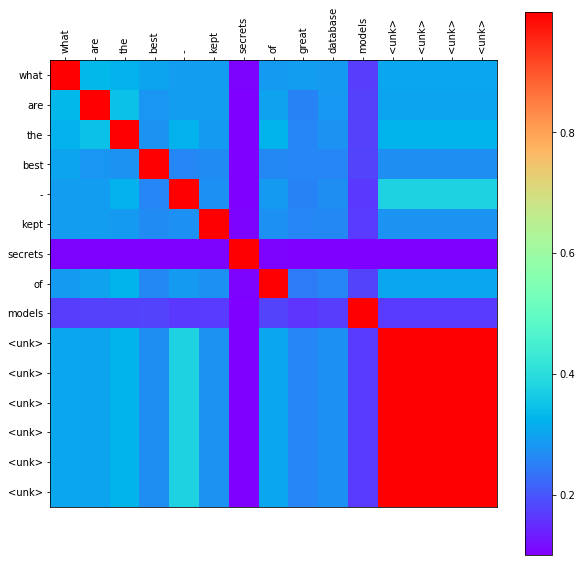

Press any key to continue...


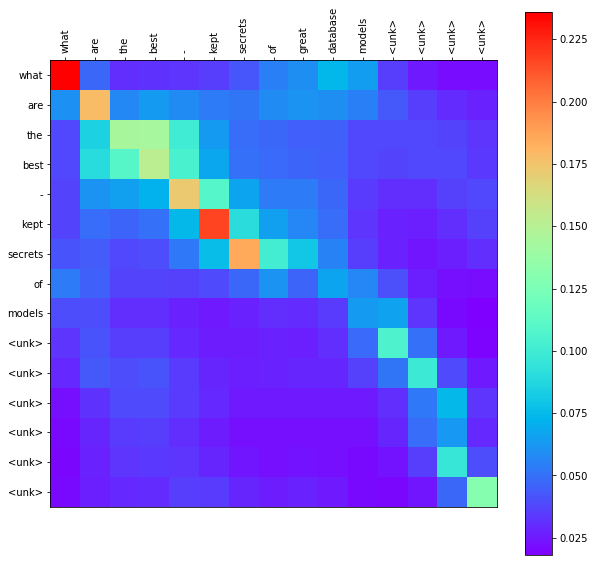

Press any key to continue...


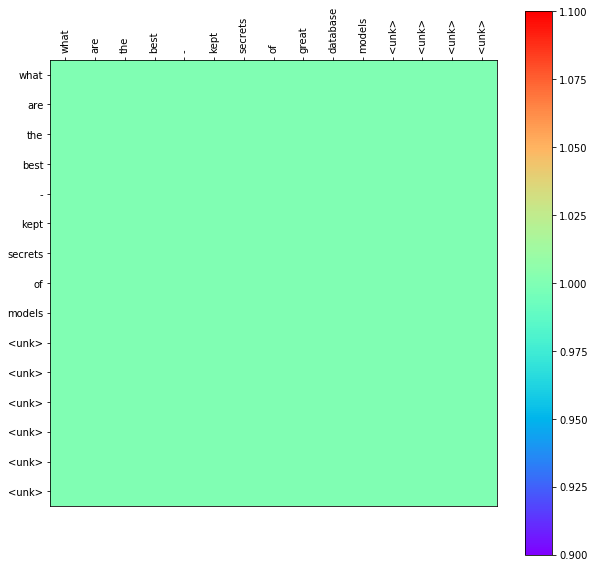

Press any key to continue...


In [66]:
# Get initial inputs to model
for example, (features, label) in zip(quora_examples, quora_dataset):
    
    # Reshape data to work with blocks
    features = features.unsqueeze(0)
    label = label.unsqueeze(0)
    
    # Get features for each question
    x0_0 = features[:, 0, :, :].unsqueeze(1)
    x1_0 = features[:, 1, :, :].unsqueeze(1)
    x0_0 = x0_0.cuda() if USE_CUDA else x0_0
    x1_0 = x1_0.cuda() if USE_CUDA else x1_0
    
    # Initial attention distribution
    A_0 = compute_attention_matrix(x0_0, x1_0, euclidean)
    A_0 = A_0.squeeze().cpu().numpy()
    generate_heat_map(A_0, example[1], example[0])
    _ = input("Press any key to continue...")
    
    # Attention distribution after first block
    x0_1, x1_1, a0_1, a1_1 = block_1(x0_0, x1_0)
    A_1 = compute_attention_matrix(x0_1, x1_1, euclidean)
    A_1 = A_1.squeeze().detach().cpu().numpy()
    generate_heat_map(A_1, example[1], example[0])
    _ = input("Press any key to continue...")

    x0_2, x1_2, a0_2, a1_2 = block_2(x0_1, x1_1)
    A_2 = compute_attention_matrix(x0_2, x1_2, euclidean)
    A_2 = A_2.squeeze().detach().cpu().numpy()
    generate_heat_map(A_2, example[1], example[0])
    _ = input("Press any key to continue...")

# Hulo Dataset

Here are a few examples from the Hulo dataset:

In [68]:
hulo_examples = [
    ["how do I find a printer?", "The printer is not working. Looks to be offline.", 1],
    ["How to connect to printer?", "I can't add the printer", 1],
    ["How do I fix the keyboard of my mac", "VPN connection fail", 0],
    ["My VPN is broken", "Can't log in with VPN", 1]
]

In [72]:
hulo_dataset, hulo_examples = setup_dataset(hulo_examples, word_vectors, embeddings_size, max_length)

100%|██████████| 4/4 [00:00<00:00, 542.25it/s]


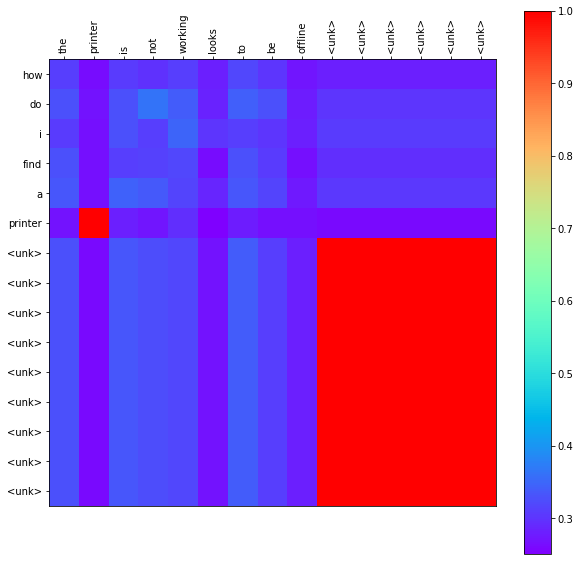

Press any key to continue...


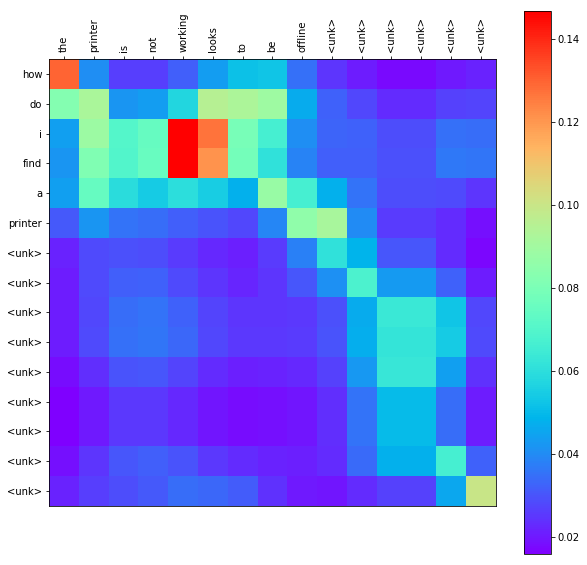

Press any key to continue...


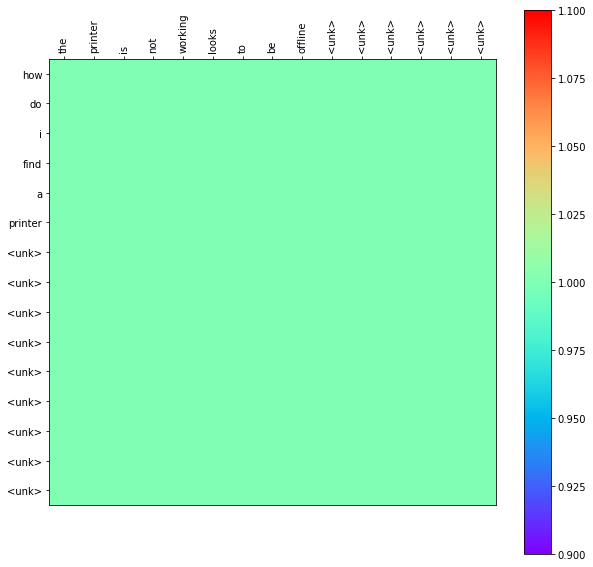

Press any key to continue...


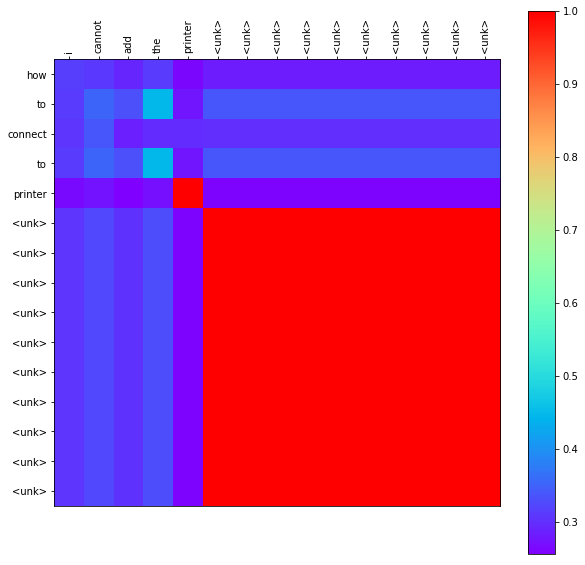

Press any key to continue...


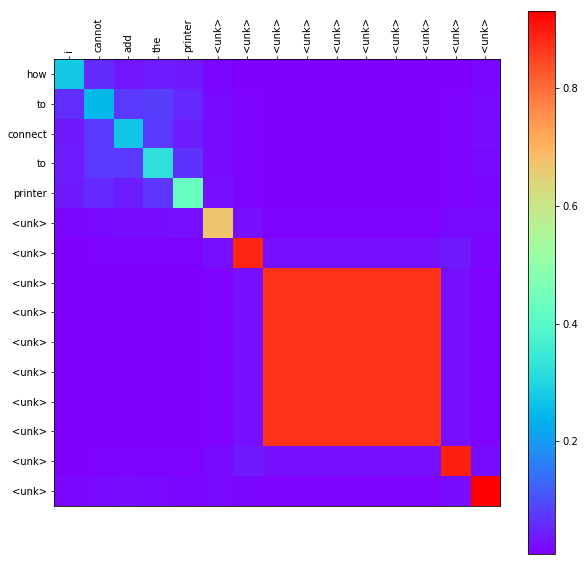

Press any key to continue...


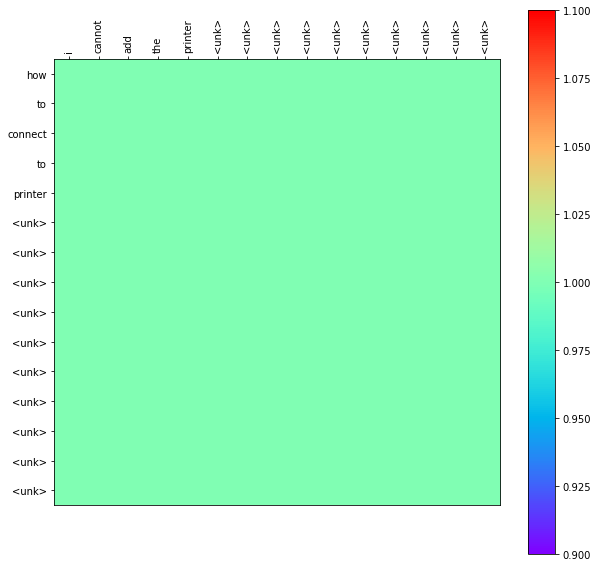

Press any key to continue...


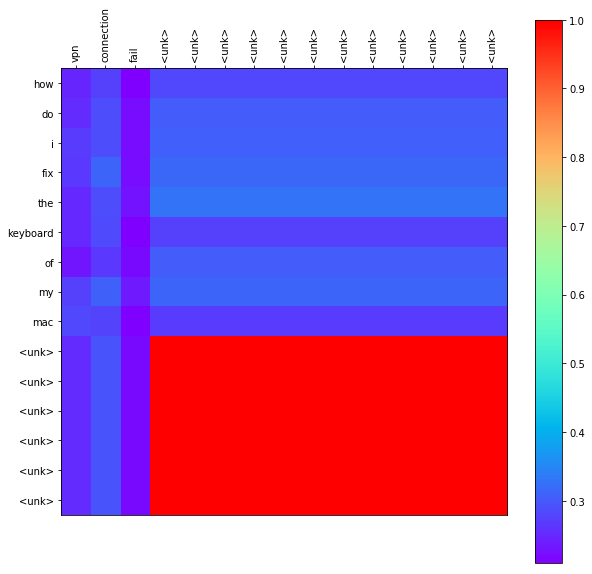

Press any key to continue...


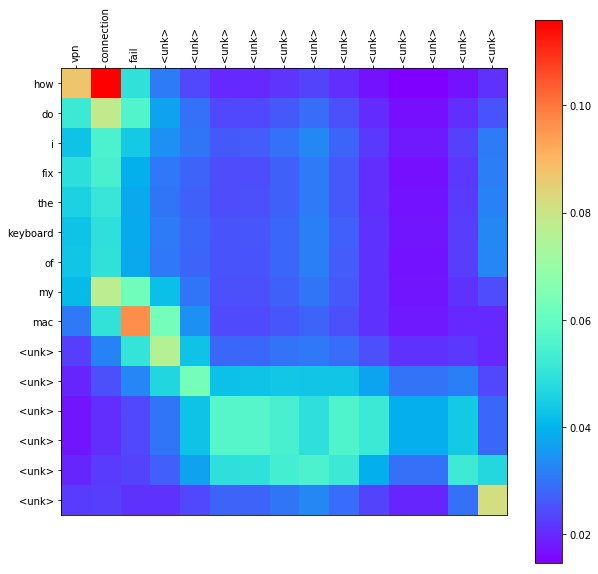

Press any key to continue...


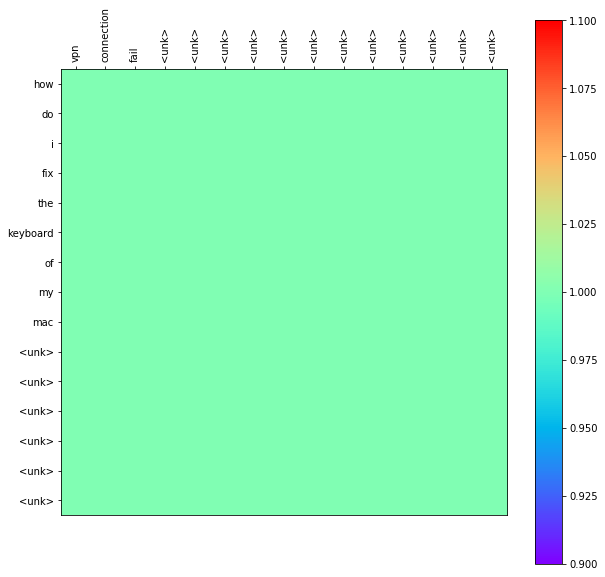

In [ ]:
# Get initial inputs to model
for example, (features, label) in zip(hulo_examples, hulo_dataset):
    
    # Reshape data to work with blocks
    features = features.unsqueeze(0)
    label = label.unsqueeze(0)
    
    # Get features for each question
    x0_0 = features[:, 0, :, :].unsqueeze(1)
    x1_0 = features[:, 1, :, :].unsqueeze(1)
    x0_0 = x0_0.cuda() if USE_CUDA else x0_0
    x1_0 = x1_0.cuda() if USE_CUDA else x1_0
    
    # Initial attention distribution
    A_0 = compute_attention_matrix(x0_0, x1_0, euclidean)
    A_0 = A_0.squeeze().cpu().numpy()
    generate_heat_map(A_0, example[1], example[0])
    _ = input("Press any key to continue...")
    
    # Attention distribution after first block
    x0_1, x1_1, a0_1, a1_1 = block_1(x0_0, x1_0)
    A_1 = compute_attention_matrix(x0_1, x1_1, euclidean)
    A_1 = A_1.squeeze().detach().cpu().numpy()
    generate_heat_map(A_1, example[1], example[0])
    _ = input("Press any key to continue...")

    x0_2, x1_2, a0_2, a1_2 = block_2(x0_1, x1_1)
    A_2 = compute_attention_matrix(x0_2, x1_2, euclidean)
    A_2 = A_2.squeeze().detach().cpu().numpy()
    generate_heat_map(A_2, example[1], example[0])
    _ = input("Press any key to continue...")